# Grating Couplers

Grating couplers are simply components of a photonic circuit that use diffraction to couple light into a waveguide. By utilizing grating couplers, we can much more efficiently use the space available on a chip, as the input/output no longer is no longer required to be at an edge. This allows us to pack more components into a smaller area, and also allows us to use the same chip for multiple purposes, as we can have multiple input/output ports.

<p align="center">
<img src="https://github.com/BYUCamachoLab/Photonics-Bootcamp/blob/main/book/images/grating_coupler.png?raw=true" alt="fishy" width="450px">
</p>

Grating couplers have a periodic structure. The rows in the image above are alternating mediums of two different refractive indexes. By having a diffraction grating with a period similar to the wavelength, the grating coupler creates interference patterns in the light which result in a diffracted mode. The specifics of how this refraction works can be described by the Huygens-Fresnel principle and Bragg's law.

# How does it work?

In [3]:
import gdsfactory as gf

@gf.cell
def simple_grating_coupler(num_teeth = 24, period = 0.2, tooth_width = 0.1, tooth_height = 2, taper_length = 5):
    c1 = gf.Component("grating tooth")
    tooth = c1 << gf.components.straight(length=tooth_width, width = tooth_height)
    
    c2 = gf.Component("grating teeth")
    a_ref = c2.add_array(
        c1, columns=num_teeth, rows=1, spacing=[period, 1]
    )
    
    c3 = gf.Component("taper")
    taper_ref = c3 << gf.components.straight(length=taper_length, width = tooth_height)

    taper_ref.movex(num_teeth * period)

    c4 = gf.Component("final")
    c4.add_ref(c2)

    c4.add_ref(c3)

    return c4

simple_grating_coupler(num_teeth=15)

Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15'\x…

simple_grating_coupler__173251f5: uid 6c3201a3, ports [], references ['grating teeth_1', 'taper_1'], 0 polygons


# Designing a Grating Coupler in GDS Factory

Let's begin our design by creating a gdsfactory cell this is done by creating a function with a unique name and the @cell decorator. Next we'll create a gds component and return it from the function. (Since we are not specifiying a PDK in this tutorial, GDS Factory will supply a default one for us)

In [2]:
import gdsfactory as gf

@gf.cell
def grating_coupler():
    component = gf.Component("my_grating_coupler")
    return component

Since we are designing a focused grating coupler, we should think about how we can easily generate the curved teeth. One method is by generating concentric circles and later cropping out a triangular portion to be the grating teeth. Let's start by writing a helper function to generate concentric circles. These circles should repeat until we get to a solid inner circle, which will become the final taper that leads into a waveguide.

**Note: gf.components.ring() generates a ring whose radius is halfway between the outer and inner radii of the ring. We can fix this manually by adding a buffer distance.

In [1]:
import gdsfactory as gf

@gf.cell
def grating_coupler():
    radius_inner_circle = 5

    def concentric_rings():
        c = gf.Component("Concentric circles")
        for i in range(10):
            initial_ring_radius = radius_inner_circle + 0.5
            circle = gf.components.ring(radius = i * 0.7 + initial_ring_radius, width = 0.35)
            c.add_ref(circle)
        return c
    
    component = gf.Component("my_grating_coupler")
    component.add_ref(concentric_rings())

    center_circle = gf.components.circle(radius=radius_inner_circle)
    component.add_ref(center_circle)

    return component

c = grating_coupler()
c

2023-06-13 08:46:04.753 | WARNING  | gdsfactory.pdk:get_active_pdk:603 - No active PDK. Activating generic PDK.



Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

grating_coupler: uid 76a05199, ports [], references ['Concentric circles_1', 'circle_1'], 0 polygons


Now, we can very easily trim the component down to the desired tapered shape by using gf.geometry.trim(). Afterwhich we should add a port to connect our geometry to a waveguide. Now we should have a very simplistic model for a grating coupler.

In [1]:
import gdsfactory as gf

@gf.cell
def grating_coupler():
    radius_inner_circle = 5

    def concentric_rings():
        c = gf.Component("Concentric circles")
        for i in range(10):
            initial_ring_radius = radius_inner_circle + 0.5
            circle = gf.components.ring(radius = i * 0.7 + initial_ring_radius, width = 0.35)
            c.add_ref(circle)
        return c
    
    component = gf.Component("my_grating_coupler")
    component.add_ref(concentric_rings())

    center_circle = gf.components.circle(radius=radius_inner_circle)
    component.add_ref(center_circle)

    triangle_length = radius_inner_circle + 2 * 10
    triangle_height = 20
    
    component = gf.geometry.trim(component=component, domain=[[0, 0.25], [0, -0.25], [-triangle_length, -triangle_height], [-triangle_length, triangle_height]])
    
    return component

c = grating_coupler()
c

2023-06-22 09:49:38.788 | WARNING  | gdsfactory.pdk:get_active_pdk:603 - No active PDK. Activating generic PDK.



Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

grating_coupler: uid fc884557, ports [], references [], 11 polygons


Now, this component represents the basic idea of a focused grating coupler in that it has refraction teeth and a taper that leads to a waveguide, however, before we simulate this component in meep, we should discuss a basic parameters and revise our design.

# Fill Factor


The fill factor ...

# Grating Period
The grating period ...

In [4]:
import gdsfactory as gf

@gf.cell
def straight(length=1, width=1, layer=(1, 0)):
    WG = gf.Component()
    WG.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    WG.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    WG.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return WG

@gf.cell
def focusing_grating_coupler(grating_period = 0.7, width = 0.35, taper_length = 20, num_teeth = 20 , port_width = 0.6):
    
    def concentric_rings():
        c = gf.Component("Concentric circles")
        for i in range(num_teeth):
            initial_radius = taper_length + grating_period - 0.5 * width
            c.add_ref(gf.components.ring(radius = initial_radius + i * grating_period, width = width))
        return c
    
    component = gf.Component("focusing_grating_coupler")
    component.add_ref(concentric_rings())

    center_circle = gf.components.circle(radius=taper_length)
    component.add_ref(center_circle)

    triangle_length = taper_length + 2 * num_teeth
    triangle_height = 20
    
    component = gf.geometry.trim(component=component, domain=[[0, port_width/2], [0, -port_width/2], [-triangle_length, -triangle_height], [-triangle_length, triangle_height]])
    component.add_port(name = "o1", center = (0,0), width=port_width, orientation = 0, layer=1)

    return component



#grating_coupler = focusing_grating_coupler(grating_period=0.7, width = 0.35, taper_length = 10, num_teeth = 24, port_width=0.5)

c = gf.Component("straights_not_connected")

grating_coupler = c << focusing_grating_coupler(grating_period=0.7, width = 0.35, taper_length = 10, num_teeth = 24, port_width=0.5)
waveguide = c << straight(length=2, width=0.5, layer=1)

waveguide.connect("o1", grating_coupler.ports["o1"])
#waveguide.movex(1)

c


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

straights_not_connected: uid f34dbf40, ports [], references ['focusing_grating_coupler_1', 'straight_1'], 0 polygons


2023-06-23 14:12:07.028 | WARNING  | gdsfactory.pdk:get_active_pdk:603 - No active PDK. Activating generic PDK.



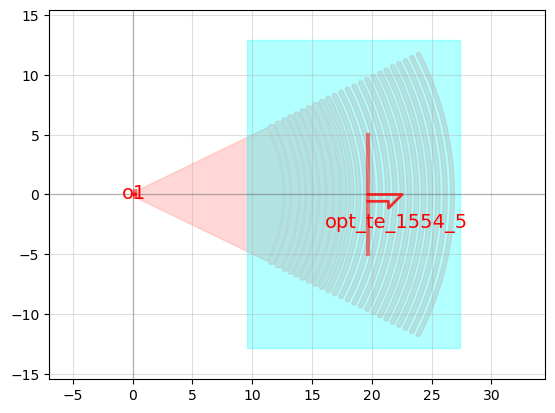

TypeError: get_simulation_grating_fiber() got an unexpected keyword argument 'xmargin_left'

In [1]:
import gdsfactory as gf
import meep as mp
import gdsfactory.simulation.gmeep as gm
import tidy3d
import gdsfactory.simulation.gtidy3d as gt


c = (
    gf.components.grating_coupler_elliptical_lumerical()
)  # inverse design grating apodized
c.plot()
#fiber_angle_deg = 5
#s = gt.get_simulation_grating_coupler(
#    c, is_3d=False, fiber_angle_deg=fiber_angle_deg, fiber_xoffset=0
#)
#f = gt.plot_simulation(s)

#c = gf.components.mmi2x2()

# Plot s-parameters simulation
gm.write_sparameters_grating(c, xmargin_left=1, xmargin_right=1, port_source_offset=-0.3, port_monitor_offset=-0.5, run=False)

# Run simulation and save results
sp = gm.write_sparameters_meep(c, xmargin_left=1, xmargin_right=1, port_source_offset=-0.3, port_monitor_offset=-0.5)